# 用每日新闻预测金融市场变化

In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import roc_auc_score
from datetime import date

## 监视数据
我们先读入数据。这里我提供了一个已经combine好了的数据。

In [3]:
data = pd.read_csv('./input/Combined_News_DJIA.csv')

这时候，我们可以看一下数据长什么样子

In [4]:
data.head()

,Date,Label,Top1,Top2,Top3,Top4,Top5,Top6,Top7,Top8,...,Top16,Top17,Top18,Top19,Top20,Top21,Top22,Top23,Top24,Top25
0,2008-08-08,0,"b""Georgia 'downs two Russian warplanes' as cou...",b'BREAKING: Musharraf to be impeached.',b'Russia Today: Columns of troops roll into So...,b'Russian tanks are moving towards the capital...,"b""Afghan children raped with 'impunity,' U.N. ...",b'150 Russian tanks have entered South Ossetia...,"b""Breaking: Georgia invades South Ossetia, Rus...","b""The 'enemy combatent' trials are nothing but...",...,b'Georgia Invades South Ossetia - if Russia ge...,b'Al-Qaeda Faces Islamist Backlash',"b'Condoleezza Rice: ""The US would not act to p...",b'This is a busy day: The European Union has ...,"b""Georgia will withdraw 1,000 soldiers from Ir...",b'Why the Pentagon Thinks Attacking Iran is a ...,b'Caucasus in crisis: Georgia invades South Os...,b'Indian shoe manufactory - And again in a se...,b'Visitors Suffering from Mental Illnesses Ban...,"b""No Help for Mexico's Kidnapping Surge"""
1,2008-08-11,1,b'Why wont America and Nato help us? If they w...,b'Bush puts foot down on Georgian conflict',"b""Jewish Georgian minister: Thanks to Israeli ...",b'Georgian army flees in disarray as Russians ...,"b""Olympic opening ceremony fireworks 'faked'""",b'What were the Mossad with fraudulent New Zea...,b'Russia angered by Israeli military sale to G...,b'An American citizen living in S.Ossetia blam...,...,b'Israel and the US behind the Georgian aggres...,"b'""Do not believe TV, neither Russian nor Geor...",b'Riots are still going on in Montreal (Canada...,b'China to overtake US as largest manufacturer',b'War in South Ossetia [PICS]',b'Israeli Physicians Group Condemns State Tort...,b' Russia has just beaten the United States ov...,b'Perhaps *the* question about the Georgia - R...,b'Russia is so much better at war',"b""So this is what it's come to: trading sex fo..."
2,2008-08-12,0,b'Remember that adorable 9-year-old who sang a...,"b""Russia 'ends Georgia operation'""","b'""If we had no sexual harassment we would hav...","b""Al-Qa'eda is losing support in Iraq because ...",b'Ceasefire in Georgia: Putin Outmaneuvers the...,b'Why Microsoft and Intel tried to kill the XO...,b'Stratfor: The Russo-Georgian War and the Bal...,"b""I'm Trying to Get a Sense of This Whole Geor...",...,b'U.S. troops still in Georgia (did you know t...,b'Why Russias response to Georgia was right',"b'Gorbachev accuses U.S. of making a ""serious ...","b'Russia, Georgia, and NATO: Cold War Two'",b'Remember that adorable 62-year-old who led y...,b'War in Georgia: The Israeli connection',b'All signs point to the US encouraging Georgi...,b'Christopher King argues that the US and NATO...,b'America: The New Mexico?',"b""BBC NEWS | Asia-Pacific | Extinction 'by man..."
3,2008-08-13,0,b' U.S. refuses Israel weapons to attack Iran:...,"b""When the president ordered to attack Tskhinv...",b' Israel clears troops who killed Reuters cam...,b'Britain\'s policy of being tough on drugs is...,b'Body of 14 year old found in trunk; Latest (...,b'China has moved 10 *million* quake survivors...,"b""Bush announces Operation Get All Up In Russi...",b'Russian forces sink Georgian ships ',...,b'Elephants extinct by 2020?',b'US humanitarian missions soon in Georgia - i...,"b""Georgia's DDOS came from US sources""","b'Russian convoy heads into Georgia, violating...",b'Israeli defence minister: US against strike ...,b'Gorbachev: We Had No Choice',b'Witness: Russian forces head towards Tbilisi...,b' Quarter of Russians blame U.S. for conflict...,b'Georgian president says US military will ta...,b'2006: Nobel laureate Aleksander Solzhenitsyn...
4,2008-08-14,1,b'All the experts admit that we should legalis...,b'War in South Osetia - 89 pictures made by a ...,b'Swedish wrestler Ara Abrahamian throws away ...,b'Russia exaggerated the death toll in South O...,b'Missile That Killed 9 Inside Pakistan May Ha...,"b""Rushdie Condemns Random House's Refusal to P...",b'Poland and US agree 

其实看起来特别的简单直观。如果是1，那么当日的DJIA就提高或者不变了。如果是1，那么DJIA那天就是跌了。

## 分割测试/训练集
这下，我们可以先把数据给分成Training/Testing data

In [5]:
train = data[data['Date'] < '2015-01-01']
test = data[data['Date'] > '2014-12-31']

然后，我们把每条新闻做成一个单独的句子，集合在一起：

In [6]:
X_train = train[train.columns[2:]]
corpus = X_train.values.flatten().astype(str)

X_train = X_train.values.astype(str)
X_train = np.array([' '.join(x) for x in X_train])
X_test = test[test.columns[2:]]
X_test = X_test.values.astype(str)
X_test = np.array([' '.join(x) for x in X_test])
y_train = train['Label'].values
y_test = test['Label'].values

这里我们注意，我们需要三样东西：  
corpus是全部我们『可见』的文本资料。我们假设每条新闻就是一句话，把他们全部flatten()了，我们就会得到list of sentences。  
同时我们的X_train和X_test可不能随便flatten，他们需要与y_train和y_test对应。

In [7]:
corpus[:3]

array(['b"Georgia \'downs two Russian warplanes\' as countries move to brink of war"',
       "b'BREAKING: Musharraf to be impeached.'",
       "b'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)'"],
      dtype='<U312')

In [8]:
X_train[:1]

array(['b"Georgia \'downs two Russian warplanes\' as countries move to brink of war" b\'BREAKING: Musharraf to be impeached.\' b\'Russia Today: Columns of troops roll into South Ossetia; footage from fighting (YouTube)\' b\'Russian tanks are moving towards the capital of South Ossetia, which has reportedly been completely destroyed by Georgian artillery fire\' b"Afghan children raped with \'impunity,\' U.N. official says - this is sick, a three year old was raped and they do nothing" b\'150 Russian tanks have entered South Ossetia whilst Georgia shoots down two Russian jets.\' b"Breaking: Georgia invades South Ossetia, Russia warned it would intervene on SO\'s side" b"The \'enemy combatent\' trials are nothing but a sham: Salim Haman has been sentenced to 5 1/2 years, but will be kept longer anyway just because they feel like it." b\'Georgian troops retreat from S. Osettain capital, presumably leaving several hundred people killed. [VIDEO]\' b\'Did the U.S. Prep Georgia for War with Ru

In [9]:
y_train[:5]

array([0, 1, 0, 0, 1])

来，我们再把每个单词给分隔开：  
同样，corpus和X_train的处理不同

In [12]:
from nltk import word_tokenize
from nltk.tokenize import word_tokenize
corpus = [word_tokenize(x) for x in corpus]
X_train = [word_tokenize(x) for x in X_train]
X_test = [word_tokenize(x) for x in X_test]

tokenize完毕后，  
我们可以看到，虽然corpus和x都是一个二维数组，但是他们的意义不同了。  
corpus里，第二维数据是一个个句子。  
x里，第二维数据是一个个数据点（对应每个label）

In [13]:
X_train[:2]

[['b',
  "''",
  'Georgia',
  "'downs",
  'two',
  'Russian',
  'warplanes',
  "'",
  'as',
  'countries',
  'move',
  'to',
  'brink',
  'of',
  'war',
  "''",
  "b'BREAKING",
  ':',
  'Musharraf',
  'to',
  'be',
  'impeached',
  '.',
  "'",
  "b'Russia",
  'Today',
  ':',
  'Columns',
  'of',
  'troops',
  'roll',
  'into',
  'South',
  'Ossetia',
  ';',
  'footage',
  'from',
  'fighting',
  '(',
  'YouTube',
  ')',
  "'",
  "b'Russian",
  'tanks',
  'are',
  'moving',
  'towards',
  'the',
  'capital',
  'of',
  'South',
  'Ossetia',
  ',',
  'which',
  'has',
  'reportedly',
  'been',
  'completely',
  'destroyed',
  'by',
  'Georgian',
  'artillery',
  'fire',
  "'",
  'b',
  "''",
  'Afghan',
  'children',
  'raped',
  'with',
  "'impunity",
  ',',
  "'",
  'U.N.',
  'official',
  'says',
  '-',
  'this',
  'is',
  'sick',
  ',',
  'a',
  'three',
  'year',
  'old',
  'was',
  'raped',
  'and',
  'they',
  'do',
  'nothing',
  "''",
  "b'150",
  'Russian',
  'tanks',
  'have',


In [14]:
corpus[:2]

[['b',
  "''",
  'Georgia',
  "'downs",
  'two',
  'Russian',
  'warplanes',
  "'",
  'as',
  'countries',
  'move',
  'to',
  'brink',
  'of',
  'war',
  "''"],
 ["b'BREAKING", ':', 'Musharraf', 'to', 'be', 'impeached', '.', "'"]]

# 预处理
我们进行一些预处理来把我们的文本资料变得更加统一：  
小写化  
删除停止词  
删除数字与符号  
lemma  
我们把这些功能合为一个func：

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/jinfan/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [17]:
# 停止词
from nltk.corpus import stopwords
stop = stopwords.words('english')

# 数字
import re
def hasNumbers(inputString):
    return bool(re.search(r'\d', inputString))

# 特殊符号
def isSymbol(inputString):
    return bool(re.match(r'[^\w]', inputString))

# lemma
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()

def check(word):
    """
    如果需要这个单词，则True
    如果应该去除，则False
    """
    word= word.lower()
    if word in stop:
        return False
    elif hasNumbers(word) or isSymbol(word):
        return False
    else:
        return True

# 把上面的方法综合起来
def preprocessing(sen):
    res = []
    for word in sen:
        if check(word):
            # 这一段的用处仅仅是去除python里面byte存str时候留下的标识。。之前数据没处理好，其他case里不会有这个情况
            word = word.lower().replace("b'", '').replace('b"', '').replace('"', '').replace("'", '')
            res.append(wordnet_lemmatizer.lemmatize(word))
    return res

把我们三个数据组都来处理一下：

In [19]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/jinfan/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

In [20]:
corpus = [preprocessing(x) for x in corpus]
X_train = [preprocessing(x) for x in X_train]
X_test = [preprocessing(x) for x in X_test]

我们再来看看处理之后的数据长相：

In [21]:
print(corpus[553])
print(X_train[523])

['north', 'korean', 'leader', 'kim', 'jong-il', 'confirmed', 'ill']
['two', 'redditors', 'climbing', 'mt', 'kilimanjaro', 'charity', 'bidding', 'peak', 'nt', 'squander', 'opportunity', 'let', 'upvotes', 'something', 'awesome', 'estimated', 'take', 'year', 'clear', 'lao', 'explosive', 'remnant', 'left', 'behind', 'united', 'state', 'bomber', 'year', 'ago', 'people', 'died', 'unexploded', 'ordnance', 'since', 'conflict', 'ended', 'fidel', 'ahmadinejad', 'slandering', 'jew', 'mossad', 'america', 'israel', 'intelligence', 'agency', 'target', 'united', 'state', 'intensively', 'among', 'nation', 'considered', 'friendly', 'washington', 'israel', 'lead', 'others', 'active', 'espionage', 'directed', 'american', 'company', 'defense', 'department', 'australian', 'election', 'day', 'poll', 'rural/regional', 'independent', 'member', 'parliament', 'support', 'labor', 'minority', 'goverment', 'julia', 'gillard', 'prime', 'minister', 'france', 'plan', 'raise', 'retirement', 'age', 'set', 'strike', 'br

## 训练NLP模型
有了这些干净的数据集，我们可以做我们的NLP模型了。  
我们先用最简单的Word2Vec

In [22]:
from gensim.models.word2vec import Word2Vec

model = Word2Vec(corpus, size=128, window=5, min_count=5, workers=4)

这时候，每个单词都可以像查找字典一样，读出他们的w2v坐标了：

In [23]:
model['ok']

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


array([ 0.11945219,  0.01787301,  0.1094913 , -0.02922749,  0.052947  ,
       -0.11110666,  0.12892574,  0.24795465, -0.10310406, -0.07617221,
        0.07396606, -0.13579506,  0.00631703, -0.26862395, -0.00177121,
       -0.3195674 ,  0.09694196, -0.039502  ,  0.09016705,  0.09627812,
        0.02972645,  0.13184656,  0.08364085,  0.07155026,  0.18532099,
        0.01075894,  0.00833485,  0.00476593,  0.06212973, -0.01374412,
        0.02734518, -0.00555175,  0.21780762,  0.07190866,  0.18388109,
       -0.02484879,  0.14789347, -0.18757652, -0.15047269, -0.13161471,
       -0.0718064 , -0.16127332,  0.19061996,  0.16094182, -0.09339662,
        0.21093354,  0.07642347, -0.02079605, -0.10555676, -0.12497178,
        0.06343588, -0.00388487, -0.11406522,  0.04088393, -0.02418771,
       -0.04791205,  0.17524444, -0.3191699 , -0.11356922, -0.01957757,
       -0.02615369,  0.07357571,  0.20264068,  0.19809704,  0.18808633,
        0.11487099,  0.02997947,  0.03308203, -0.16281502, -0.22

## 用NLP模型表达我们的X
接着，我们于是就可以用这个坐标，来表示我们的之前干干净净的X。  
但是这儿有个问题。我们的vec是基于每个单词的，怎么办呢？  
由于我们文本本身的量很小，我们可以把所有的单词的vector拿过来取个平均值：

In [25]:
# 先拿到全部的vocabulary
vocab = model.wv.vocab

# 得到任意text的vector
def get_vector(word_list):
    # 建立一个全是0的array
    res =np.zeros([128])
    count = 0
    for word in word_list:
        if word in vocab:
            res += model[word]
            count += 1
    return res/count   

此时，我们得到了一个取得任意word list平均vector值得方法：

In [26]:
get_vector(['hello', 'from', 'the', 'other', 'side'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


array([ 9.22246241e-02,  8.05329141e-03,  1.13367795e-01, -1.67436074e-02,
        5.54379394e-02, -1.12923465e-01,  1.16010103e-01,  2.69467662e-01,
       -1.14165702e-01, -6.44151506e-02,  6.91505130e-02, -1.36122140e-01,
        9.47168749e-03, -2.93455373e-01,  1.04739366e-03, -3.48724596e-01,
        1.09918646e-01, -6.03832933e-03,  1.27608603e-01,  1.02555342e-01,
        3.11770057e-02,  1.43369495e-01,  1.12200204e-01,  8.42480762e-02,
        2.16662718e-01,  1.19099551e-02,  2.28690436e-02,  7.42463017e-04,
        8.32306064e-02,  7.87566975e-03,  3.31026824e-02,  6.88641175e-03,
        2.24486334e-01,  8.97485120e-02,  2.02085328e-01, -5.75501192e-02,
        1.55404483e-01, -1.91140344e-01, -1.71438158e-01, -1.29162919e-01,
       -8.19102484e-02, -1.68210121e-01,  2.22135931e-01,  1.42748193e-01,
       -9.08065718e-02,  2.25792386e-01,  8.08133774e-02, -2.25964349e-02,
       -9.55599619e-02, -1.52388516e-01,  8.13449291e-02,  2.65684873e-02,
       -1.24590817e-01,  

这样，我们可以同步把我们的X都给转化成128维的一个vector list  
（为了之后内容的方便，我先把之前我们处理好的wordlist给存下来。）

In [27]:
wordlist_train = X_train
wordlist_test = X_test

X_train = [get_vector(x) for x in X_train]
X_test = [get_vector(x) for x in X_test]

print(X_train[10])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  # This is added back by InteractiveShellApp.init_path()


[ 0.1408202   0.02608833  0.11874303 -0.01075096  0.04621869 -0.16004641
  0.22191582  0.45246776 -0.18572625 -0.10162875  0.13046553 -0.18468021
  0.01339504 -0.46744691 -0.04258229 -0.53611177  0.1991944  -0.01354792
  0.17126471  0.19469828  0.0302702   0.25358464  0.16291352  0.13901077
  0.27314227 -0.01523472  0.00921461  0.05621169  0.0663531   0.01053673
 -0.01139012  0.03743988  0.36047279  0.10986399  0.29885871 -0.05413174
  0.23459735 -0.31770535 -0.26894314 -0.20817828 -0.14811503 -0.21972189
  0.35278828  0.25944052 -0.14351011  0.33342742  0.16449347  0.02434514
 -0.11683109 -0.22050454  0.09018892 -0.03969866 -0.18292829  0.08347419
 -0.07223802 -0.11897     0.33768028 -0.55842407 -0.14870065 -0.04918994
 -0.02057086  0.17083857  0.3052724   0.25382508  0.24414931  0.14514986
  0.05076232  0.02684404 -0.32518895 -0.4652688  -0.15338991  0.53461487
  0.20815625 -0.01715285  0.24900771 -0.22179587 -0.06193294  0.39232969
  0.40351978  0.09413772  0.00133812  0.06128205  0

## 建立ML模型 
这里，因为我们128维的每一个值都是连续关系的。不是分裂开考虑的。所以，道理上讲，我们是不太适合用RandomForest这类把每个column当做单独的  variable来看的方法。（当然，事实是，你也可以这么用）  
好的，我们来看看比较适合连续函数的方法：SVM

In [28]:
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score

params = [0.1,0.5,1,3,5,7,10,12,16,20,25,30,35,40]
test_scores = []
for param in params:
    clf = SVR(gamma=param)
    test_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
    test_scores.append(np.mean(test_score))

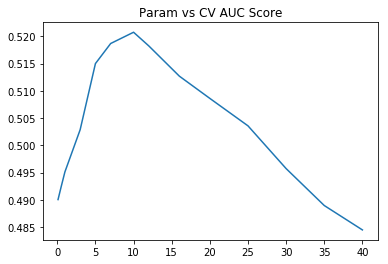

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(params, test_scores)
plt.title("Param vs CV AUC Score");

## 用CNN来提升逼格
有些同学也许会说，这也太扯了吧，直接平均了一下vec值，就能拿来跑？  
哈哈，当然不会这么简单。  
我们必然是有更严谨的处理方式。  
比如：  
用vector表示出一个大matrix，并用CNN做“降维+注意力”   
（为了演示的方便，下面内容我会把整个case搞得简单点。要是想更加复杂准确的话，直接调整参数，往大了调，就行）  
首先，我们确定一个padding_size。  
什么是padding size？  
就是为了让我们生成的matrix是一样的size啊。。  
（这里其实我们可以最简单地调用keras的sequence方法来做，但是我想让大家更清楚的明白一下，内部发生了什么）  

In [30]:
# 说明，对于每天的新闻，我们会考虑前256个单词。不够的我们用[000000]补上
# vec_size 指的是我们本身vector的size
def transform_to_matrix(x, padding_size=256, vec_size=128):
    res = []
    for sen in x:
        matrix = []
        for i in range(padding_size):
            try:
                matrix.append(model[sen[i]].tolist())
            except:
                # 这里有两种except情况，
                # 1. 这个单词找不到
                # 2. sen没那么长
                # 不管哪种情况，我们直接贴上全是0的vec
                matrix.append([0] * vec_size)
        res.append(matrix)
    return res

这时候，我们把我们原本的word list跑一遍：

In [31]:
X_train = transform_to_matrix(wordlist_train)
X_test = transform_to_matrix(wordlist_test)

print(X_train[123])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  if __name__ == '__main__':


[[0.09496494382619858, 0.0449536107480526, 0.2308671772480011, -0.26063600182533264, 0.018558453768491745, -0.353969007730484, 0.34006547927856445, 0.2630479633808136, -0.07657509297132492, -0.18168790638446808, 0.11892513185739517, 0.11033487319946289, -0.10672391206026077, -0.7942834496498108, -0.04104643315076828, -0.7238245010375977, 0.16397719085216522, 0.20833398401737213, 0.44533321261405945, -0.05589492619037628, 0.24762459099292755, 0.15677611529827118, 0.251489520072937, 0.25299033522605896, 0.4889894425868988, 0.07708805054426193, -0.09250525385141373, -0.08149334043264389, -0.13291896879673004, 0.04558722674846649, 0.30552875995635986, -0.2352537363767624, 0.6077331304550171, 0.17925521731376648, 0.3263498544692993, -0.1637323796749115, 0.21397025883197784, -0.25754302740097046, -0.3588900566101074, -0.39824509620666504, -0.16353407502174377, -0.3624431788921356, 0.3438853323459625, -0.01208055205643177, -0.1734468936920166, -0.0902954488992691, 0.18983469903469086, 0.13153

可以看到，现在我们得到的就是一个大大的Matrix，它的size是 128 * 256  
每一个这样的matrix，就是对应了我们每一个数据点  
在进行下一步之前，我们把我们的input要reshape一下。  
原因是我们要让每一个matrix外部“包裹”一层维度。来告诉我们的CNN model，我们的每个数据点都是独立的。之间木有前后关系。  
（其实对于股票这个case，前后关系是存在的。这里不想深究太多这个问题。有兴趣的同学可以谷歌CNN+LSTM这种强大带记忆的深度学习模型。）

In [32]:
# 搞成np的数组，便于处理
X_train = np.array(X_train)
X_test = np.array(X_test)

# 看看数组的大小
print(X_train.shape)
print(X_test.shape)

(1611, 256, 128)
(378, 256, 128)


In [33]:
X_train = X_train.reshape(X_train.shape[0], 1, X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], 1, X_test.shape[1], X_test.shape[2])

print(X_train.shape)
print(X_test.shape)

(1611, 1, 256, 128)
(378, 1, 256, 128)


接下来，我们安安稳稳的定义我们的CNN模型

In [47]:
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten

# set parameters:
batch_size = 32
n_filter = 16
filter_length = 4
nb_epoch = 5
n_pool = 2

# 新建一个sequential的模型
model = Sequential()
model.add(Convolution2D(n_filter,filter_length,filter_length,dim_ordering='th',
                        input_shape=( 1,256,128)))
model.add(Activation('relu'))
model.add(Convolution2D(n_filter,filter_length,filter_length))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(n_pool, n_pool)))
model.add(Dropout(0.25))
model.add(Flatten())
# 后面接上一个ANN
model.add(Dense(128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('softmax'))
# compile模型
model.compile(loss='mse',
              optimizer='adadelta',
              metrics=['accuracy'])

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:16: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (4, 4), input_shape=(1, 256, 1..., data_format="channels_first")`
  app.launch_new_instance()
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (4, 4))`


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


接着，我们就可以放进我们的xy了

In [48]:
model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch,
          verbose=0)
score = model.evaluate(X_test, y_test, verbose=0)
print('Test score:', score[0])
print('Test accuracy:', score[1])

Instructions for updating:
Use tf.cast instead.


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  


Test score: 0.4920634922211763
Test accuracy: 0.5079365098287189


## 思考：
虽然我们这里使用了word2vec，但是对CNN而言，管你3721的input是什么，只要符合规矩，它都可以process。  
这其实就给了我们更多的“发散”空间：  
我们可以用ASCII码（0，256）来表达每个位置上的字符，并组合成一个大大的matrix。  
这样牛逼之处在于，你都不需要用preprocessing了，因为每一个字符的可以被表示出来，并且都有意义。  
另外，你也可以使用不同的分类器：  
我们这里使用了最简单的神经网络~  
你可以用LSTM或者RNN等接在CNN的那句Flatten之后